In [1]:
import preprocess as p
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from scipy.signal import find_peaks_cwt
import os

%matplotlib inline

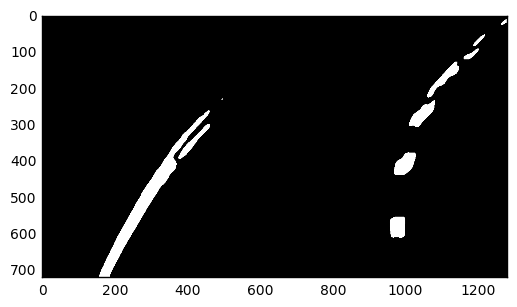

In [122]:
image =  mpimg.imread(os.path.join("test_images", "test3.jpg"))
im = p.preprocess(image)


one = mpimg.imread(os.path.join("newpics", "1000.jpg"))
two = mpimg.imread(os.path.join("newpics", "556.jpg"))
three = mpimg.imread(os.path.join("newpics", "557.jpg"))
four = mpimg.imread(os.path.join("newpics", "558.jpg"))

plt.imshow(im, cmap='gray')

In [88]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 

        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = None
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        
        self.prev_rad = []
        
        self.prev_pos = []
        
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 

        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
        self.skipped = 0
        
        
        self.count = 0

In [140]:
leftLine, rightLine = Line(), Line()

In [141]:

def detect_lanes_sliding(im, left, right):
# Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(im[int(im.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((im, im, im))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    histogram = np.sum(im[int(im.shape[0]/2):,:], axis=0)
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(int(im.shape[0]/nwindows))
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = im.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = im.shape[0] - (window+1)*window_height
        win_y_high = im.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    left.best_fit = left_fit
    right.best_fit = right_fit
    
    left.allx = leftx
    right.allx = rightx
    
    left.ally = lefty
    right.ally = righty

In [142]:
imone = detect_lanes_sliding(im, leftLine, rightLine)

In [143]:
def mask(im, image, left, right):

    Minv = p.inv()
    
    left_fit = left.best_fit
    right_fit = right.best_fit

    ploty = np.linspace(0, im.shape[0]-1, im.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(im).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(p.undistort(image), 1, newwarp, 0.3, 0)
    
    center = relCenter(leftLine, rightLine)


    result = cv2.putText(result, "{}{}".format("Left Curvature: ", radCurve(leftLine)), (600, 60), 
                                             cv2.FONT_HERSHEY_DUPLEX , 1., (255, 255, 255))

    result = cv2.putText(result, "{}{}".format("Right Curvature: ", radCurve(rightLine)), (600, 100), 
                                             cv2.FONT_HERSHEY_DUPLEX , 1., (255, 255, 255))

    result = cv2.putText(result, p.cent(center), (600, 140), 
                                             cv2.FONT_HERSHEY_DUPLEX , 1., (255, 255, 255))

    return result


In [138]:
leftLine.best_fit

array([  4.21562671e-04,  -1.05000315e+00,   7.08566111e+02])

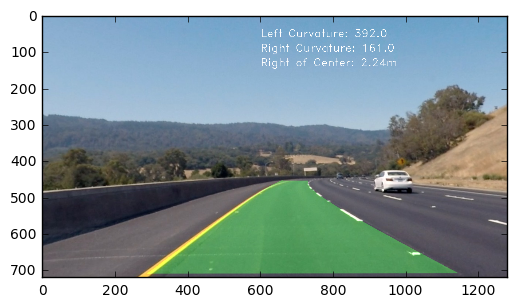

In [144]:
result = mask(im, image, leftLine, rightLine)
plt.imshow(result)

In [44]:
two = mpimg.imread(os.path.join("newpics", "556.jpg"))

im = p.preprocess(three)

In [45]:
def detect_noSliding(im, left, right):
    
    left_fit = left.best_fit
    right_fit = right.best_fit

    nonzero = im.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, im.shape[0]-1, im.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


In [113]:
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(im[im.shape[0]/2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((im, im, im))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(im.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = im.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = im.shape[0] - (window+1)*window_height
    win_y_high = im.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

C:\Users\sijuade\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


(720, 0)

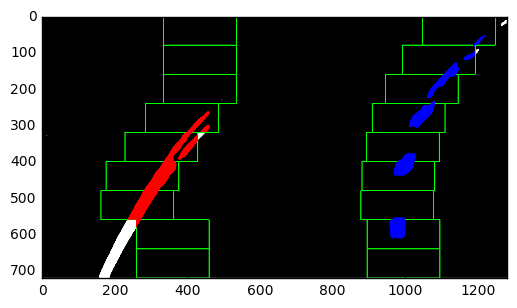

In [115]:

left_fit = leftLine.best_fit
right_fit = rightLine.best_fit


# Generate x and y values for plotting
ploty = np.linspace(0, im.shape[0]-1, im.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
#plt.plot(left_fitx, ploty, color='yellow')
#plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


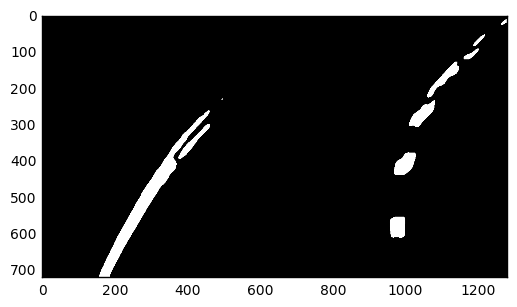

In [95]:
plt.imshow(im, cmap='gray')

In [130]:
SHAPE = [im.shape[0], im.shape[1]]

In [118]:
def radCurve(line):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    
    y_eval = np.max(line.ally)
    
    # Fit new polynomials to x,y in world space
    coef = np.polyfit(line.ally*ym_per_pix, line.allx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    curverad = ((1 + (2*coef[0]*y_eval*ym_per_pix + coef[1])**2)**1.5) / np.absolute(2*coef[0])
    
    curverad = (int(curverad) * 100.0) / 100.0
    
    return curverad

    
def relCenter(left, right):
    
    # Bottom pixel for Lane Line
    l = left.best_fit[0] * SHAPE[0]-1 **2 + left.best_fit[1] * SHAPE[0]-1 + left.best_fit[2]
    r = right.best_fit[0] * SHAPE[0]-1 **2 + right.best_fit[1] * SHAPE[0]-1 + right.best_fit[2]
    
    xm_per_pix = 3.7/700
        
    return int((((SHAPE[1] / 2) - (l + r) / 2) * xm_per_pix)*100) / 100.0

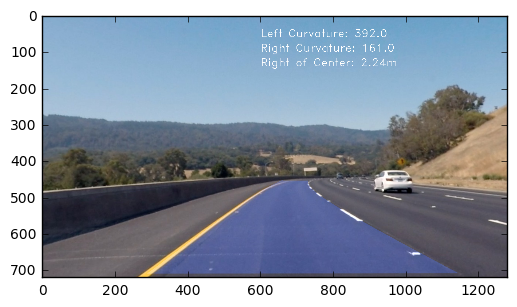

In [147]:
warp_zero = np.zeros_like(im).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,50, 200))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(p.undistort(image), 1, newwarp, 0.3, 0)

center = relCenter(leftLine, rightLine)


result = cv2.putText(result, "{}{}".format("Left Curvature: ", radCurve(leftLine)), (600, 60), 
                                         cv2.FONT_HERSHEY_DUPLEX , 1., (255, 255, 255))

result = cv2.putText(result, "{}{}".format("Right Curvature: ", radCurve(rightLine)), (600, 100), 
                                         cv2.FONT_HERSHEY_DUPLEX , 1., (255, 255, 255))

result = cv2.putText(result, p.cent(center), (600, 140), 
                                         cv2.FONT_HERSHEY_DUPLEX , 1., (255, 255, 255))

plt.imshow(result)

plt.imsave("result.jpg", result)